# 04 Define extreme temperature thresholds #

In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import xarray as xr
import pandas as pd
import netCDF4 as nc
import numpy as np
from dask.distributed import Client
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sys.path.append('/home/563/sc1326/repos/cdrmip_extremes')
from cdrmip_extremes.configs import data_dir, models, expts
from cdrmip_extremes.load_data import load_raw_tas
from cdrmip_extremes import ext_freq
from cdrmip_extremes.plotting import plot_extremes

In [2]:
client = Client(memory_limit=None,threads_per_worker=1,n_workers=28)

## Load temperature data ##

In [3]:
data = load_raw_tas()

#### Step 1: Calculate the month of maximum & minimum temperature for each grid cell from each model's PI simulation ####

In [4]:
pi_data = {model: data[model]['piControl'] for model in models}

In [5]:
# extract localised month of maximum temperature for each grid cell of each model
ext_results = {model:{} for model in models}
for model, ds in pi_data.items():
    max_months = ds.groupby('time.month').mean(dim='time').idxmax(dim='month')
    min_months = ds.groupby('time.month').mean(dim='time').idxmin(dim='month')
    ext_results[model]['max_months'] = max_months
    ext_results[model]['min_months'] = min_months

In [5]:
extreme_months = {
    model: ext_freq.monthly_extrema(ds) for model, ds in pi_data.items()
}

In [5]:
# then extract temperatures from only the hottest or coldest months
# this may take a minute or two
extreme_months = pi_datatree.map_over_datasets(ext_freq.monthly_extrema_dt)

#### Plot hottest/coldest months ####

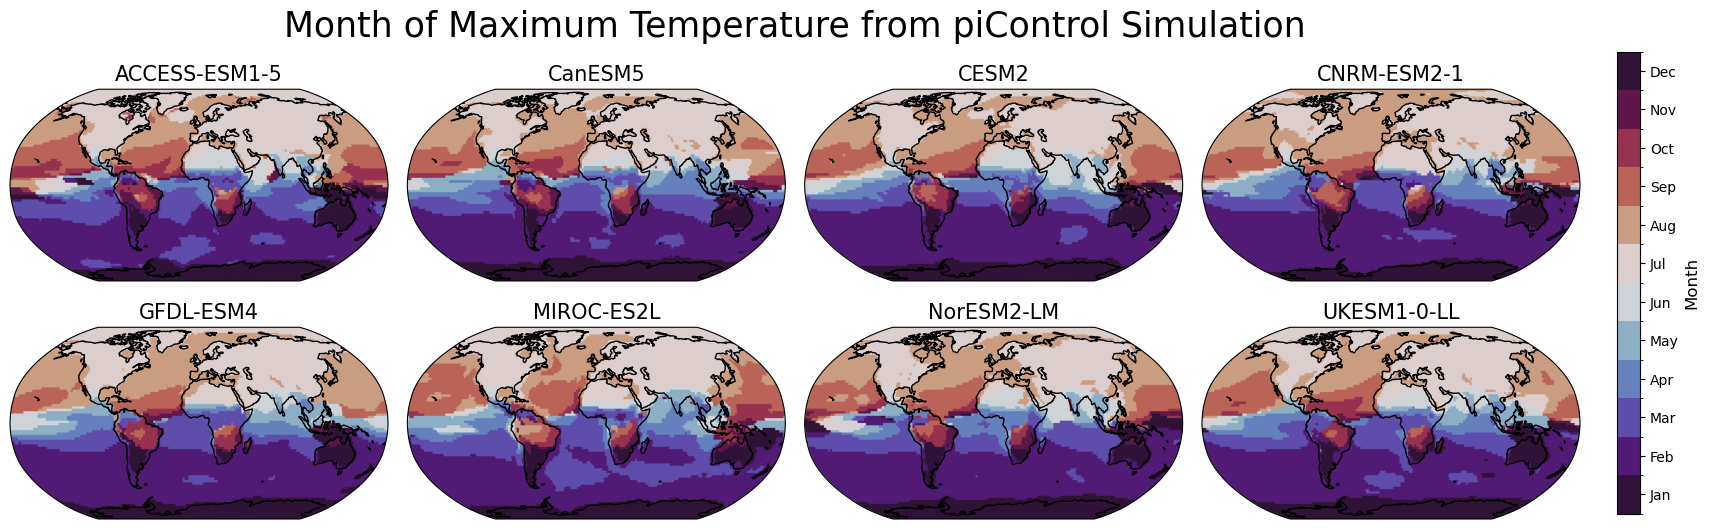

In [7]:
plot_extremes.plot_hottest_coldest_month(
    extreme_months,
    'max',
    "Month of Maximum Temperature from piControl Simulation"
)

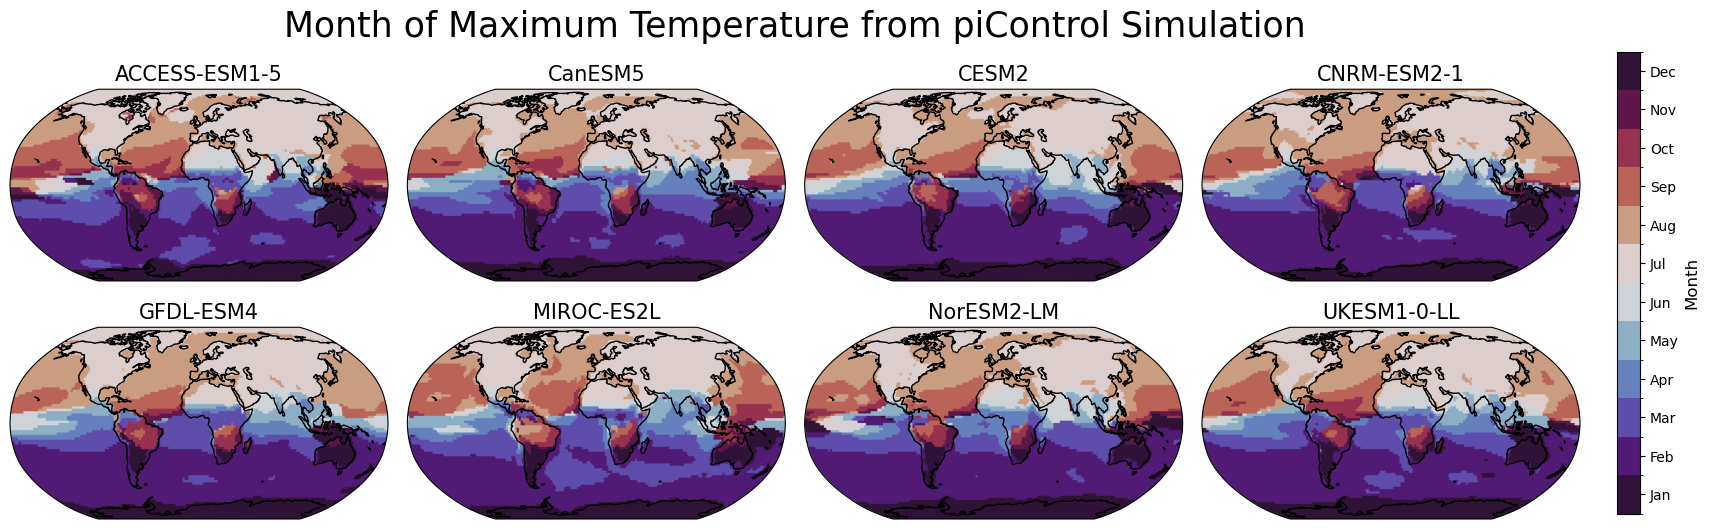

In [7]:
plot_extremes.plot_hottest_coldest_month(
    extreme_months,
    'max',
    "Month of Maximum Temperature from piControl Simulation"
)

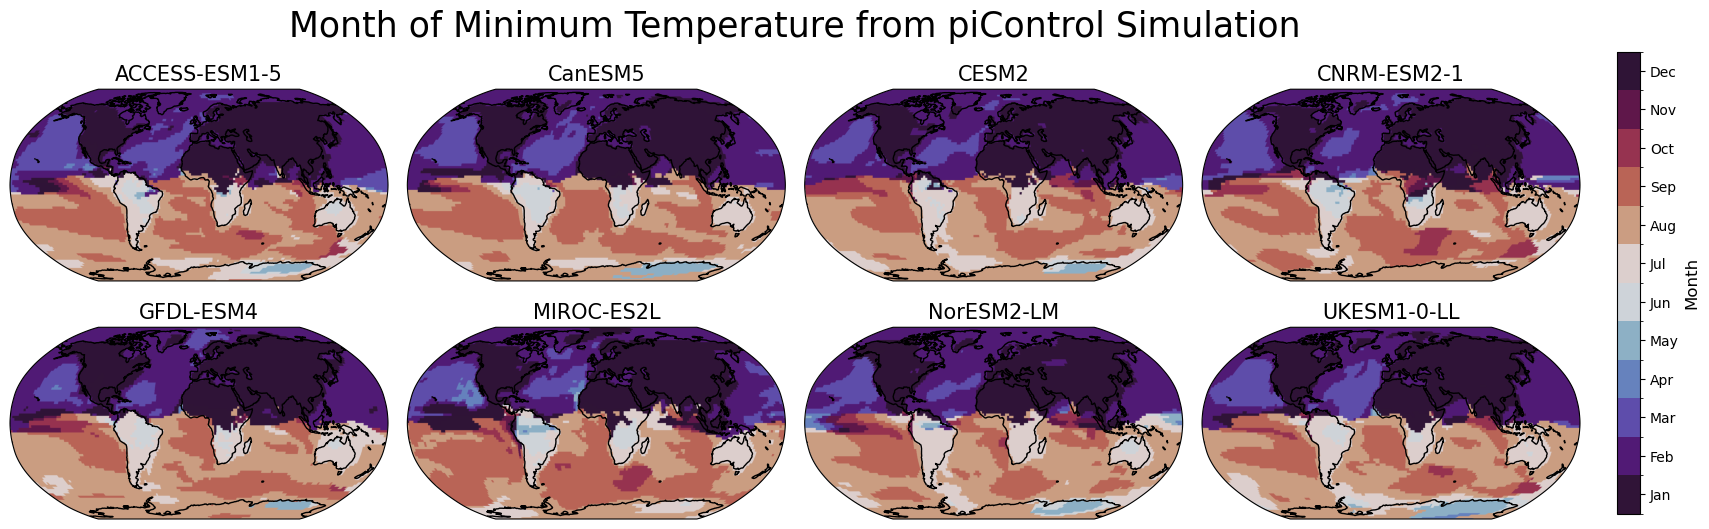

In [8]:
plot_extremes.plot_hottest_coldest_month(
    extreme_months,
    'min',
    "Month of Minimum Temperature from piControl Simulation"
)

#### Step 2 & Step 3: Calculate the monthly means and standard deviations for each grid cell's month of maximum temperature ####

In [18]:
ext_results = {model:{} for model in models}
for model, dt in extreme_months.items():
    ext_results[model]['extreme_months'] = dt.ds

In [7]:
# for model, ds in pi_data.items():
#     monthly_extremes = ext_freq.monthly_extrema(ds)
#     for extrema in ['max','min']:
#         months = monthly_extremes.month.sel(extrema=extrema)
#         ext_results[model][f"{extrema}_months"] = months
#         ext_results[model][f"{extrema}_month_mean"] =  ext_freq.extreme_month_stat(ds,months,'mean')
#         ext_results[model][f"{extrema}_month_std_dev"] = ext_freq.extreme_month_stat(ds,months,'std')

In [8]:
for model, dt in pi_datatree.items():
    ds = dt.ds.tas
    for extrema in ['max','min']:
        months = extreme_months[model].ds.month.sel(extrema=extrema)
        ext_results[model][f"{extrema}_month_mean"] =  ext_freq.extreme_month_stat(ds,months,'mean')
        ext_results[model][f"{extrema}_month_std_dev"] = ext_freq.extreme_month_stat(ds,months,'std')

#### Plot Monthly Means and Standard Deviation for Hottest/Coldest Months ####

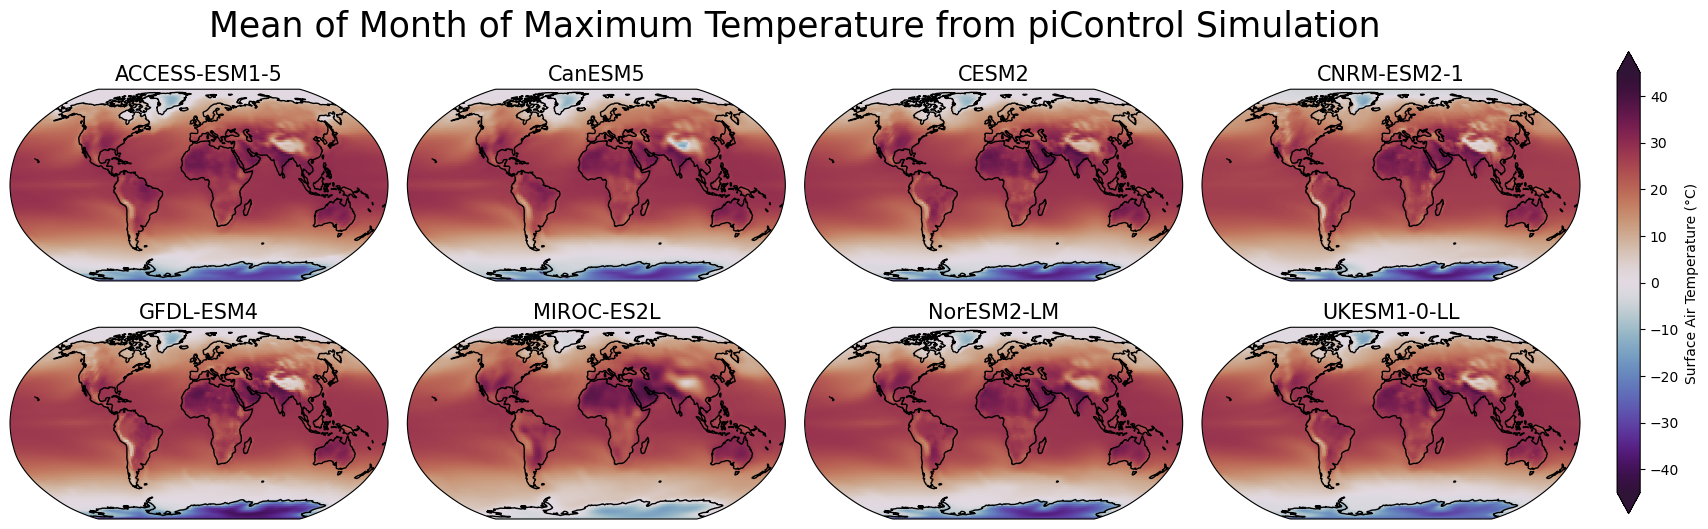

In [10]:
plot_extremes.plot_pi_stats(
    ext_results,
    'max_month_mean',
    cmap='twilight_shifted',
    vmin=-45,
    vmax=45,
    cbar_label="Surface Air Temperature (°C)",
    title="Mean of Month of Maximum Temperature from piControl Simulation"
)

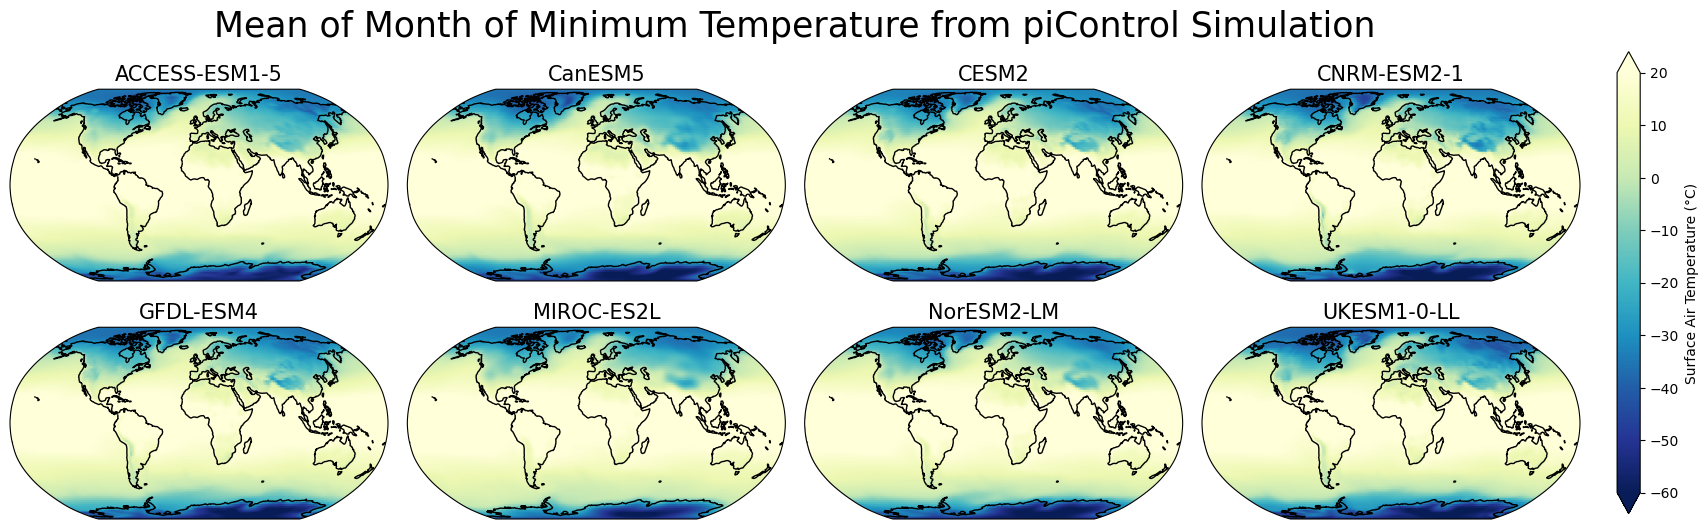

In [11]:
plot_extremes.plot_pi_stats(
    ext_results,
    'min_month_mean',
    cmap='YlGnBu_r',
    vmin=-60,
    vmax=20,
    cbar_label="Surface Air Temperature (°C)",
    title="Mean of Month of Minimum Temperature from piControl Simulation"
)

In [12]:
custom_color = plt.cm.inferno_r
custom_cmap = ListedColormap(custom_color(np.linspace(0.2, 0.8, 128)))

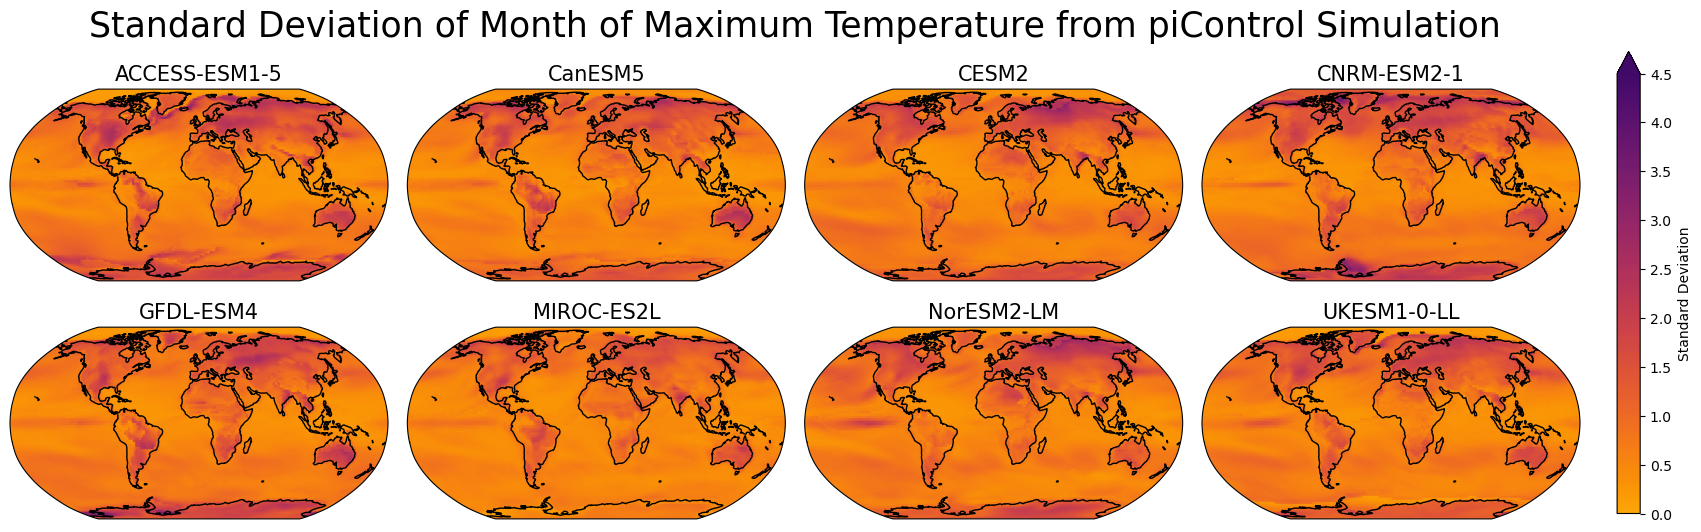

In [13]:
plot_extremes.plot_pi_stats(
    ext_results,
    'max_month_std_dev',
    cmap=custom_cmap,
    vmin=0,
    vmax=4.5,
    cbar_label="Standard Deviation",
    title="Standard Deviation of Month of Maximum Temperature from piControl Simulation"
)

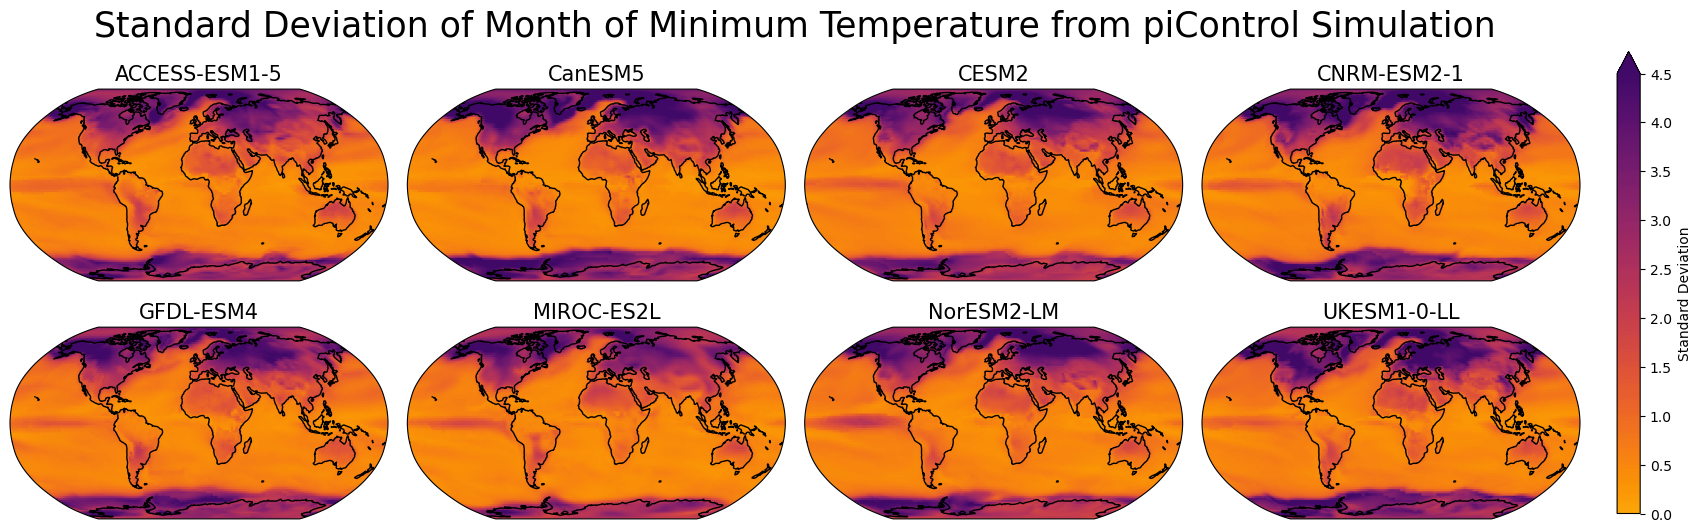

In [14]:
plot_extremes.plot_pi_stats(
    ext_results,
    'min_month_std_dev',
    cmap=custom_cmap,
    vmin=0,
    vmax=4.5,
    cbar_label="Standard Deviation",
    title="Standard Deviation of Month of Minimum Temperature from piControl Simulation"
)

#### Step 4: Calculate extreme temperature thresholds based on standard deviations from mean hottest/coldest month temperaturs ####

In [9]:
for model, ds_dict in ext_results.items():
    ext_results[model]['heat_thresholds'] = ext_freq.heat_extreme_thresholds(
        ds_dict['max_month_mean'],
        ds_dict['max_month_std_dev']
    )
    ext_results[model]['cold_thresholds'] = ext_freq.cold_extreme_thresholds(
        ds_dict['min_month_mean'],
        ds_dict['min_month_std_dev']
    )

#### Save ####

In [20]:
save_dir = os.path.join(
    data_dir,'processed/extremes'
)
for model, ds_dict in ext_results.items():
    for var, ds in ds_dict.items():
        var_dir = os.path.join(save_dir,var)
        os.makedirs(var_dir,exist_ok=True)
        path = os.path.join(
            var_dir,
            f"{model}_{var}.nc"
        )
        ds.to_netcdf(path)